In [1]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from allennlp.modules.elmo import Elmo, batch_to_ids

import pickle



DS = pd.read_csv("ObjectSubset150SentenceLength.csv")
DS['tag'].fillna('text', inplace=True)
words = list(set(DS["word"].values))
n_words = len(words)
tags = list(set(DS["tag"].values))
n_tags = len(tags)

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(DS)
sentences = getter.sentences

max_len = 10
tags2 = ["PAD","object","text"]
tag2idx = {t: i  for i, t in enumerate(tags2)}
# tag2idx["PAD"] = 0

X = [[w[0] for w in s] for s in sentences]

new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PAD")
    new_X.append(new_seq)
X = new_X

y = [[tag2idx[w[1]] for w in s] for s in sentences]

from keras.preprocessing.sequence import pad_sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"], truncating='post')

idx2tag = {i: w for w, i in tag2idx.items()}

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=2018)
batch_size = 32


options_file = "options.json"
weight_file = "swb_weights.hdf5"
elmo_model  = Elmo(options_file, weight_file, 2, dropout=0)



# X_tr_character_ids = batch_to_ids(X_tr)
# X_tr_embeddings = elmo_model(X_tr_character_ids)
# pickle.dump(X_tr_embeddings, open('X_tr_embeddings.pickle', 'wb'))

# X_te_character_ids = batch_to_ids(X_te)
# X_te_embeddings = elmo_model(X_te_character_ids)
# pickle.dump(X_te_embeddings, open('X_te_embeddings.pickle', 'wb'))


Using TensorFlow backend.


In [2]:
# import tensorflow.compat.v1 as tf
# from keras import backend as K

# # import tensorflow_hub as hub
# # from keras import backend as K
# # sess = tf.Session()

# # init = tf.global_variables_initializer() # This reinitializes keras weights, so must be put before Keras loading
# sess.run(init)
# sess.run(tf.global_variables_initializer())
# K.set_session(sess)

import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K


In [3]:
# sess = tf.Session()
# K.set_session(sess)


In [4]:
from allennlp.modules.elmo import Elmo, batch_to_ids
options_file = "options.json"
weight_file = "swb_weights.hdf5"
elmo_model  = Elmo(options_file, weight_file, 2, dropout=0)


In [5]:
# from keras.models import Model, Input
# from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda


In [6]:
# X_tr_character_ids = batch_to_ids(X_tr)
# X_tr_embeddings = elmo_model(X_tr_character_ids)

# X_te_character_ids = batch_to_ids(X_te)
# X_te_embeddings = elmo_model(X_te_character_ids)

In [7]:
# Load pickle files that was prepared in UT server.
with open('X_tr_embeddings_fixed_Tags.pickle', 'rb') as f:
    X_tr_embeddings = pickle.load(f)

with open('X_te_embeddings_fixed_Tags.pickle', 'rb') as f:
    X_te_embeddings = pickle.load(f)

In [8]:
X_tr_embeddings['elmo_representations'][1].detach().numpy().shape

(10914, 10, 1024)

In [9]:
# sess.run(tf.compat.v1.global_variables_initializer())
# sess.run(tf.compat.v1.tables_initializer())
# def ElmoEmbedding(x):
#     return elmo_model(inputs={
#                             "tokens": tf.squeeze(tf.cast(x, tf.string)),
#                             "sequence_len": tf.constant(batch_size*[max_len])
#                       },
# #                       signature="tokens",
#                       as_dict=True)["elmo"]

# from keras.models import Model, Input
# from keras.layers.merge import add
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# input_text = Input(shape=(max_len,), dtype=tf.string)
# embedding = Lambda(ElmoEmbedding, output_shape=(None, 1024))(input_text)
# x = Bidirectional(LSTM(units=512, return_sequences=True,
#                        recurrent_dropout=0.2, dropout=0.2))(embedding)
# x_rnn = Bidirectional(LSTM(units=512, return_sequences=True,
#                            recurrent_dropout=0.2, dropout=0.2))(x)
# x = add([x, x_rnn])  # residual connection to the first biLSTM
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)


In [10]:
X_tr_embeddings["elmo_representations"][1].shape

torch.Size([10914, 10, 1024])

In [11]:
y_tr.shape

(10914, 10)

In [12]:
from keras.models import Sequential
from keras.layers import LSTM, core, Activation, Dense
import numpy as np
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


model = Sequential()
# model.add(TimeDistributed(LSTM(units=20,input_shape=(10, 1024), return_sequences=False,
#                                 recurrent_dropout=0.5)))

# # main LSTM
# model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(50, input_shape=(10, 1024), return_sequences=True,recurrent_dropout=0.5)))

model.add(TimeDistributed(Dense(3, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [13]:
history = model.fit(X_tr_embeddings['elmo_representations'][1].detach().numpy(), y_tr.reshape(y_tr.shape[0],10,1),validation_split=0.1 ,verbose=1,epochs=10,batch_size=32)

Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 7s 737us/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.0063 - val_accuracy: 0.9985
Epoch 2/10
9822/9822 [==============================] - 7s 693us/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.0047 - val_accuracy: 0.9985
Epoch 3/10
9822/9822 [==============================] - 7s 684us/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9986
Epoch 4/10
9822/9822 [==============================] - 7s 682us/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoch 5/10
9822/9822 [==============================] - 7s 684us/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0041 - val_accuracy: 0.9988
Epoch 6/10
9822/9822 [==============================] - 7s 671us/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0038 - val_accuracy: 0.9989
Epoch 7/10
9822/9822 [==============================] - 7s 695us/step - loss

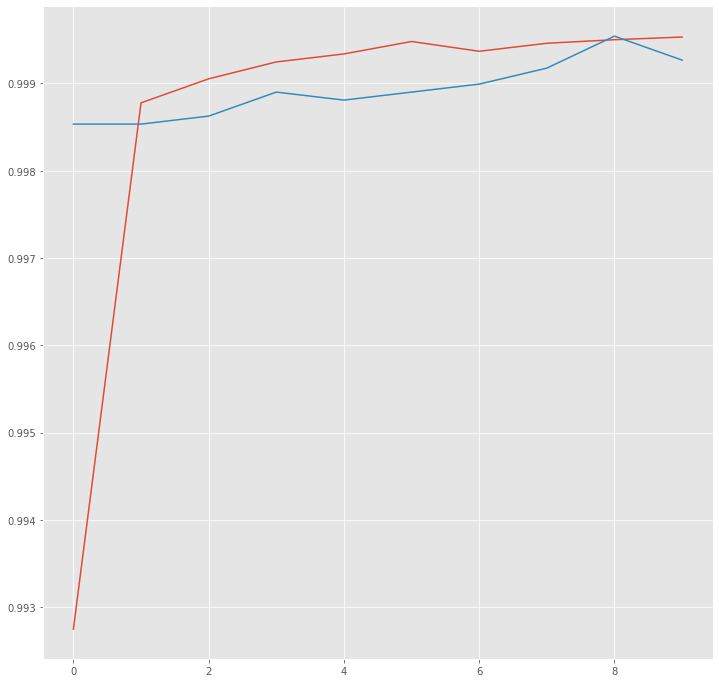

In [14]:
hist = pd.DataFrame(history.history)
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()


In [15]:
y_pred = model.predict(X_te_embeddings['elmo_representations'][1].detach().numpy(),verbose=1)

2729/2729 [==============================] - 1s 201us/step


In [16]:
y_pred[1]

array([[5.91309515e-07, 4.22106768e-06, 9.99995232e-01],
       [8.45411250e-07, 1.57628128e-05, 9.99983430e-01],
       [3.92480661e-06, 1.78147908e-04, 9.99817908e-01],
       [9.41007045e-07, 1.05832305e-05, 9.99988437e-01],
       [2.51788492e-06, 2.28941499e-05, 9.99974608e-01],
       [8.91626187e-05, 9.59484398e-01, 4.04263698e-02],
       [1.95069340e-04, 8.31615984e-01, 1.68188900e-01],
       [6.89852095e-05, 3.03061702e-03, 9.96900439e-01],
       [6.79481673e-05, 1.47941115e-03, 9.98452663e-01],
       [3.07388746e-06, 6.52813469e-05, 9.99931693e-01]], dtype=float32)

In [17]:
y_te[1]

array([2, 2, 2, 2, 2, 1, 1, 2, 2, 2])

In [18]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
            out_i.append(idx2tag[p_i].replace("PAD","text"))
        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PAD","text"))
        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [19]:
# i = 4
# p = np.argmax(y_pred[i], axis=-1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")
# for w, t, pred in zip(X_tr_embeddings[i], y_te[i], p):
#     if w != 0:
#         print("{:15}: {:5} {}".format(w, t, pred))


In [20]:
y_pred[1]

array([[5.91309515e-07, 4.22106768e-06, 9.99995232e-01],
       [8.45411250e-07, 1.57628128e-05, 9.99983430e-01],
       [3.92480661e-06, 1.78147908e-04, 9.99817908e-01],
       [9.41007045e-07, 1.05832305e-05, 9.99988437e-01],
       [2.51788492e-06, 2.28941499e-05, 9.99974608e-01],
       [8.91626187e-05, 9.59484398e-01, 4.04263698e-02],
       [1.95069340e-04, 8.31615984e-01, 1.68188900e-01],
       [6.89852095e-05, 3.03061702e-03, 9.96900439e-01],
       [6.79481673e-05, 1.47941115e-03, 9.98452663e-01],
       [3.07388746e-06, 6.52813469e-05, 9.99931693e-01]], dtype=float32)

In [21]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

      object       0.99      0.99      0.99      2422
        text       1.00      1.00      1.00     24868

    accuracy                           1.00     27290
   macro avg       1.00      0.99      0.99     27290
weighted avg       1.00      1.00      1.00     27290



In [22]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 98.4%


In [23]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

   object       0.99      0.98      0.98      1466
     text       0.99      0.98      0.98      3594

micro avg       0.99      0.98      0.98      5060
macro avg       0.99      0.98      0.98      5060



In [24]:
# sentences = [['minu', 'nimi' ,'on', 'nesma', 'hästi', 'Eemaldatud', '700', 'ml', 'plasmat','RR',' 112/60',' mmHg'], ['Pt.', 'tehtud' ,'plasmaferees', 'talus', 'hästi']]
# character_ids = batch_to_ids(sentences)
# embeddings = elmo(character_ids)

In [25]:
# embeddings['elmo_representations'][1].shape

In [26]:
# embeddings['elmo_representations'][1][1][4].detach().numpy()

In [27]:
# scipy.spatial.distance.cosine(embeddings['elmo_representations'][1][1][4].detach().numpy(),embeddings['elmo_representations'][1][1][1].detach().numpy())